# Notebook containing the figures

In [434]:
import torch
import matplotlib.pyplot as plt 
import os
import datetime
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
import json
FOLDER = 'figures'
SIMULATION_FOLDER = 'simulations'
GRAPHS_ID = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
graph_folder = os.path.join(FOLDER, GRAPHS_ID)
os.makedirs(graph_folder, exist_ok=True)
n_iterations = 10

## Functions used for positive and negative updates

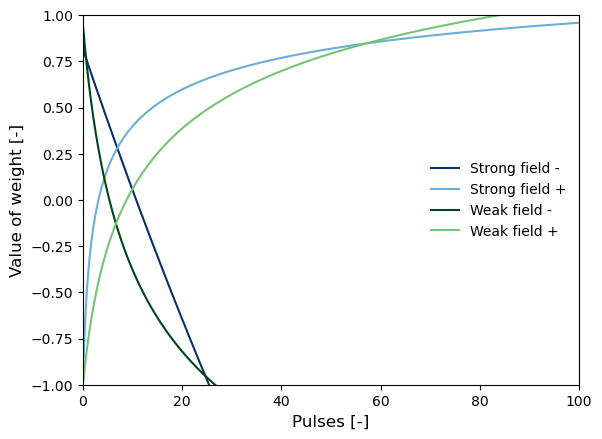

In [435]:
scale = 1
f_strong_minus = lambda x: scale * (2*(-24.77 * \
                torch.log(0.287*torch.log(x+128))+9.11)-1)
f_strong_plus = lambda x: scale * (2*(0.443 * \
                torch.log(2.53*torch.log(x+1.66)) - 0.11)-1)

f_weak_minus = lambda x: scale * \
                (-2.56*torch.log(0.997*torch.log(x+5.02)) + 2.166)
f_weak_plus = lambda x: scale * \
                (1.8132 * torch.log(1.176*torch.log(x+4.42))-2.014)
# plot all functions
fig, ax = plt.subplots()
x = torch.linspace(0, 100, 1000)
shades_blue = plt.get_cmap('Blues_r', 3)
shades_green = plt.get_cmap('Greens_r', 3)
ax.plot(x, f_strong_minus(x), label="Strong field -", color=shades_blue(0))
ax.plot(x, f_strong_plus(x), label="Strong field +", color=shades_blue(1))
ax.plot(x, f_weak_minus(x), label="Weak field -", color=shades_green(0))
ax.plot(x, f_weak_plus(x), label="Weak field +", color=shades_green(1))
ax.legend(loc='center right', fontsize=10, frameon=False)
ax.set_xlabel("Pulses [-]", fontsize=12)
ax.set_ylabel("Value of weight [-]", fontsize=12)
# export
name = "weight-evolution-" + GRAPHS_ID
ax.set_ylim(-scale, scale)
ax.set_xlim(0, 100)
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')

## Load dataframe from simulation

In [436]:
# Create a pandas dataframe with columns type, mean, std, learning rate
df = pd.DataFrame()
# get all paths
paths = [f for f in os.listdir(SIMULATION_FOLDER) if os.path.isdir(os.path.join(SIMULATION_FOLDER, f))]
for path in paths:
    try:
        # first dim of the tensor is the iteration
        accuracies = []
        mean_abs_grad = []
        weights = ""
        for it in range(n_iterations):
            current_folder = os.path.join(SIMULATION_FOLDER, path)
            accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
            mean_abs_grad.append(torch.load(os.path.join(current_folder, path+f"-{it}-gradients.pth")))
            if it == 0:
                weights = path+f"-{it}-weights.pth"    
                jfile = path+f"-{it}.json"
                parameters = json.load(open(os.path.join(current_folder, jfile), "r"))
        accuracies = torch.stack(accuracies)    
        mean = accuracies.mean(dim=0)[-1].item()*100
        std = accuracies.std(dim=0)[-1].item()*100
        mean_abs_grad = torch.stack(mean_abs_grad).mean(dim=0)[0].item()
        # print parameters but well formatted
        task = parameters["task"]
        n_devices = parameters["optimizer_parameters"]["field"][0].split("-")[0]
        type_devices = parameters["optimizer_parameters"]["field"][0].split("-")[1]
        learning_rate = float(parameters["optimizer_parameters"]["lr"])
        scale = parameters["optimizer_parameters"]["scale"]
        noise = parameters["optimizer_parameters"]["noise"]
        var = parameters["optimizer_parameters"]["device_variability"]
        clipping = parameters["optimizer_parameters"]["clipping"]
        input_scale = parameters["input_scale"]
        output_scale = parameters["output_scale"]
        df = df.append({"task": task,
                        "type_devices": type_devices,
                        "n_devices": n_devices,
                        "learning_rate": learning_rate,
                        "weights_path": weights,
                        "mean": mean,
                        "std": std,
                        "scale": scale,
                        "noise": noise,
                        "mean_abs_grad": mean_abs_grad,
                        "var": var,
                        "clipping": clipping,
                        "input_scale": input_scale,
                        "output_scale": output_scale}, ignore_index=True)
    except Exception as e:
        pass
df

,clipping,input_scale,learning_rate,mean,mean_abs_grad,n_devices,noise,output_scale,scale,std,task,type_devices,var,weights_path
0,0.0,0.001,100.0,88.985997,0.012735,double,0.015,1000.0,1.0,0.392915,MNIST,linear,0.2,20240724154312-MNIST-double-linear-100.0-switc...
1,0.0,0.001,100.0,92.953998,0.002767,double,0.015,1000.0,1.0,0.188868,MNIST,exponential,0.2,20240724154527-MNIST-double-exponential-100.0-...
2,0.0,0.001,250.0,91.672003,0.022419,double,0.015,1000.0,1.0,0.248632,MNIST,linear,0.2,20240724154750-MNIST-double-linear-250.0-switc...
3,0.0,0.001,250.0,93.850994,0.005146,double,0.015,1000.0,1.0,0.178415,MNIST,exponential,0.2,20240724155003-MNIST-double-exponential-250.0-...
4,0.0,0.001,500.0,93.151999,0.034518,double,0.015,1000.0,1.0,0.251652,MNIST,linear,0.2,20240724155228-MNIST-double-linear-500.0-switc...
5,0.0,0.001,500.0,93.809003,0.008066,double,0.015,1000.0,1.0,0.260276,MNIST,exponential,0.2,20240724155433-MNIST-double-exponential-500.0-...
6,0.0,0.001,1000.0,94.123000,0.053351,double,0.015,1000.0,1.0,0.168724,MNIST,linear,0.2,20240724155651-MNIST-double-linear-1000.0-swit...
7,0.0,0.001,1000.0,93.050003,0.013946,double,0.015,1000.0,1.0,0.284567,MNIST,exponential,0.2,20240724155900-MNIST-double-exponential-1000.0...
8,0.0,0.001,2500.0,94.279003,0.096171,double,0.015,1000.0,1.0,0.181687,MNIST,linear,0.2,20240724160115-MNIST-double-linear-2500.0-swit...
9,0.0,0.001,2500.0,90.496999,0.033606,double,0.015,1000.0,1.0,0.425181,MNIST,exponential,0.2,20240724160320-MNIST-double-exponential-2500.0...


## Accuracy vs learning rate

Plotting task MNIST with noise 0.015 and clipping 0.0


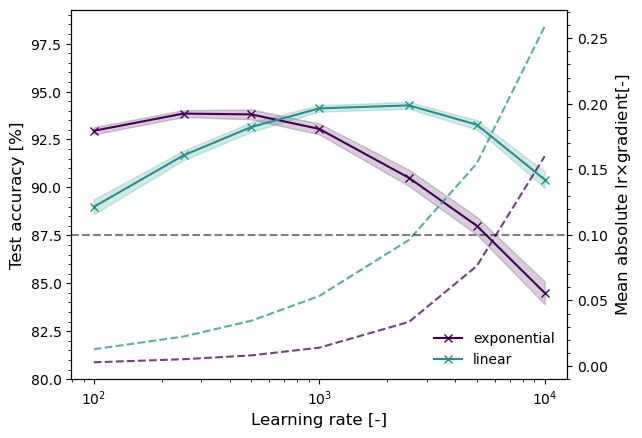

Plotting task MNIST with noise 0.015 and clipping 0.1


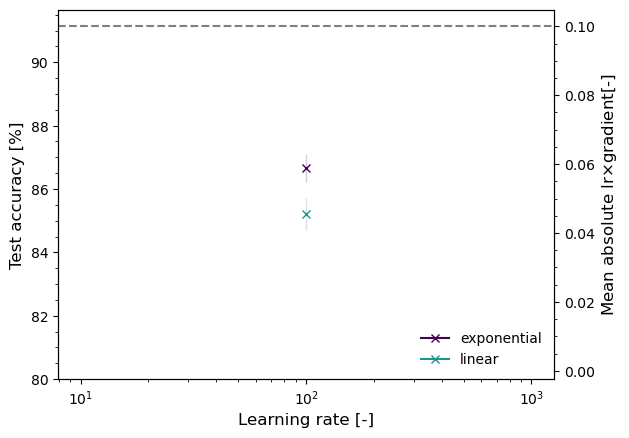

In [439]:
# for each task, plot the evolution of the accuracy
for clip in df["clipping"].unique():
    for task in df["task"].unique():
        for noise in df["noise"].unique():
            df_filtered = df[(df["task"] == task) & (df["noise"] == noise) & (df["clipping"] == clip)].sort_values("learning_rate")
            print(f"Plotting task {task} with noise {noise} and clipping {clip}")
            fig, ax = plt.subplots()
            ax2 = ax.twinx()
            palette = plt.get_cmap('viridis', len(df["type_devices"].unique())+1)
            for i, (name, group) in enumerate(df_filtered.groupby("type_devices")):
                ax.plot(group["learning_rate"], group["mean"], label=name, color=palette(i), marker='x')
                ax.fill_between(group["learning_rate"], group["mean"]-group["std"], group["mean"]+group["std"], alpha=0.2, color=palette(i))
                ax2.plot(group["learning_rate"], group["mean_abs_grad"], linestyle='--', color=palette(i), alpha=0.75, zorder=-1)
            # hline for ax2 at 0.1
            ax2.axhline(0.1, color='black', linestyle='--', alpha=0.5, label="Physically viable")
            ax2.set_ylabel(r"Mean absolute lr$\times$gradient[-]", fontsize=12)
            ax.set_xlabel("Learning rate [-]", fontsize=12)
            ax.set_ylabel("Test accuracy [%]", fontsize=12)
            ax.legend(loc='lower right', fontsize=10, frameon=False)
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax2.yaxis.set_minor_locator(AutoMinorLocator())
            offset = 5
            minimum = 80 if task == "MNIST" else 80
            maximum = min(100, df_filtered["mean"].max() + offset)
            ax.set_ylim([minimum, maximum])
            ax.set_ylim([minimum, maximum])
            # log x 
            ax.set_xscale('log')
            plt.show()
            # save as pdf and svg
            name = f"learning-rate-{task}-noise-{noise}-{GRAPHS_ID}"
            fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')